In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seastar as ss
import seastar.oscar
import seastar.retrieval
import seastar.gmfs
import cartopy.crs as ccrs
import cartopy.feature as cfeature


In [2]:
# Data load and pre-processing
oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\Brest_Sample_Oct_13_2022_precompute\\"
#oscar_path = "D:\\data\\SEASTAR\\SEASTARex\\Data\\Metasensing\\OSCAR\\May22_full_precompute\\"
#oscar_path = "D:\\data\\oscar\\Brest_Sample_Oct_13_2022\\"
file_time_triplets = ss.utils.tools.find_file_triplets(oscar_path)

print('OSCAR L1 processing')
print('-------------------')
print('File path :', oscar_path)
print('-------------------')
for i in range(len(file_time_triplets)):
    print('File index :', i, ',', 'Aquisition time :', file_time_triplets[i][0], ',', 'File list indices :', file_time_triplets[i][1])
file_index = 0 #Process single file from list below
ds = ss.utils.readers.load_OSCAR_data(oscar_path, file_time_triplets[file_index][1])
#antenna_ident = ss.utils.tools.antenna_idents(ds)
antenna_ident = ss.utils.tools.identify_antenna_location_from_filename(oscar_path, file_time_triplets[file_index][1])
ds = ss.oscar.level1.fill_missing_variables(ds, antenna_ident)
print('Processing file index',file_index)

OSCAR L1 processing
-------------------
File path : D:\data\SEASTAR\SEASTARex\Data\Metasensing\OSCAR\Brest_Sample_Oct_13_2022_precompute\
-------------------
File index : 0 , Aquisition time : 20220517T093239 , File list indices : [0, 1, 2]
File index : 1 , Aquisition time : 20220525T080646 , File list indices : [3, 4, 5]
File index : 2 , Aquisition time : 20220525T085452 , File list indices : [6, 7, 8]
Processing file index 0


In [5]:
# L1 processing
window = 7
for i in list(ds.keys()):
    ds[i] = ss.oscar.level1.check_antenna_polarization(ds[i])
    ds[i] = ss.oscar.level1.compute_multilooking_Master_Slave(ds[i], window)
    ds[i]['Baseline'] = ss.oscar.level1.compute_antenna_baseline(0.2)
    ds[i] = ss.oscar.level1.compute_antenna_azimuth_direction(ds[i], antenna=antenna_ident[list(ds.keys()).index(i)])
    ds[i] = ss.oscar.level1.compute_time_lag_Master_Slave(ds[i], options='from_SAR_time')
    ds[i] = ss.oscar.level1.compute_radial_surface_velocity(ds[i])
#Build L1 dataset
dsl1 = ss.oscar.level1.merge_beams(ds, antenna_ident)
# Generating geophysical data fields for GMF doppler computation
u10 = 10 # wind speed
wind_direction = 150 # wind direction
aux = ss.oscar.level1.init_auxiliary(dsl1,u10,wind_direction)
# Compute RSC
#dsl1 = ss.oscar.level1.compute_radial_surface_current(dsl1, aux, gmf='mouche12')
dsl1 = compute_radial_surface_current(dsl1, aux, gmf='mouche12')
# Compute Sigma0
sigma_0 = ss.gmfs.nrcs.compute_nrcs(dsl1, aux)
#L2 Processing
# Initialise l2 dataset
dsl2=ss.oscar.level1.init_level2(dsl1)
# Compute current magnitude and direction
dsl2=seastar.retrieval.level2.compute_current_magnitude_and_direction(dsl1, dsl2)

<Axes.ArtistList of 0 images>

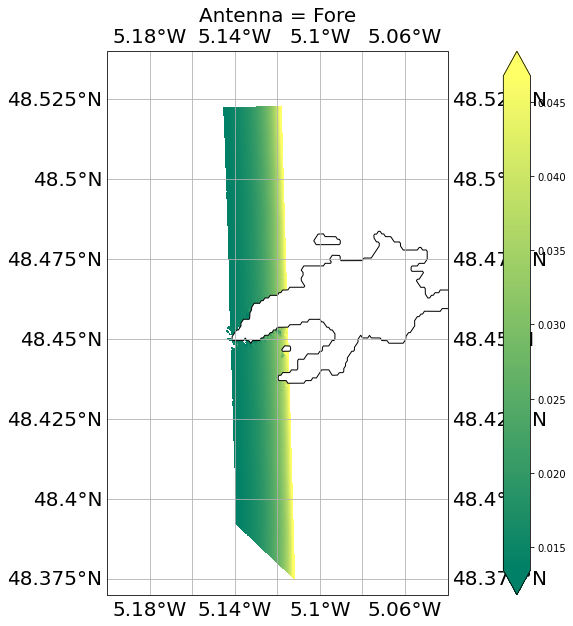

In [20]:

fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(1,1,1, projection=ccrs.Mercator())
sigma_0\
.sel(Antenna='Fore')\
.plot(
    y='latitude',
    x='longitude',
    robust=True, 
    cmap='summer',
    #vmin=0, vmax=1.5,
    transform=ccrs.PlateCarree()
)

gl=ax.gridlines(draw_labels=True)
ax.set_extent([-5.2, -5.04, 48.37, 48.54], crs=ccrs.PlateCarree())
ax.add_feature(cfeature.GSHHSFeature(scale='full',facecolor='white'))

gl.xlabel_style = {'size': 20, 'color': 'black'}
gl.ylabel_style = {'size': 20, 'color': 'black'}
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
             ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(20)
plt.gca().images